In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from time import time
script_dir = os.getcwd()

import tensorflow as tf
from tensorflow import keras

# to plot pretty histograms
#import seaborn as sns
import pandas as pd

from sde.SDE_AM_lib import (
    SDEAMTrain,
    NNHyperparameters
)

from sde.experiment_reports import \
(
    plot_results_functions,
    generate_results,
    plot_results_1d,
    probability_density,
    histogram_data,
    plot_histogram
)
from gillespie.sir import SIRG

%load_ext autoreload
%autoreload 2

2025-01-17 18:42:35.277737: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-17 18:42:35.281986: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-01-17 18:42:35.282000: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [28]:
"""
Using the transformed variables
    xi = arctanh(theta*2-1)
    theta = tanh(xi)/2+1/2
    so that we have values from -infty to +infty for xi (theta goes from 0 to 1)
"""


# def to_theta(xi):
#     return np.tanh(xi)/2+1/2


# def from_theta(th):
#     eps_safe = 1e-16
#     return np.arctanh(np.clip(th*2-1, -1+eps_safe, 1-eps_safe))


"""
Do not use transformation.
"""


def to_theta(xi):
    return xi


def from_theta(th):
    return th

In [29]:
n_dimensions = 2

# VAE parameters
n_latent_dimensions = 2
n_layers = 2
n_dim_per_layer = 20
LEARNING_RATE = 2e-4

BATCH_SIZE = 128
N_EPOCHS = 100
ACTIVATIONS = tf.nn.leaky_relu

# SIR model paramters
k1, k2 = 1, 1
N = 1024

# training data parameters
n_trajectories = 250
n_time_per_trajectory = .2
time_step = 1e-4
n_skip_steps = 10 # how many time steps to skip of the training data, to artificially increase time step

random_state = 1

tf.random.set_seed(random_state)

In [52]:
# create Gillespie training data
rng = np.random.default_rng(random_state)

sirg = SIRG(N=N, k1=k1, k2=k2, k3=0)

x_data = []
y_data = []
times = []
step_sizes = []

y0_all = []

for k in range(n_trajectories):
    # randomly sample the unit cube
    y0 = rng.uniform(low=0.0, high=1.0, size=(3,))

    # transform to sample more points on the boundary
    # y0 = (np.tanh((y0-.5)*5)+1)/2

    # make sure we only sample admissible initial conditions
    y0 = np.clip(y0, 0, 1)
    y0 = y0/np.sum(y0)

    # only take the first two
    y0 = y0[:2]

    y0_all.append(y0)

y0_all = np.row_stack(y0_all)
time_g, y = sirg.simulate(y0_all, time_max = n_time_per_trajectory, time_step=time_step)
#print(y0_all)
#print(time_g)
#print(y)

for k in range(len(y)):
    # skip simulated time steps for the training data, so that the individual points are further apart in time
    time_g[k] = time_g[k][::n_skip_steps]
    y[k] = y[k][::n_skip_steps,:]

    if len(time_g[k]) > 2:
        times.extend(time_g[k][:-1])
        step_sizes.extend(np.gradient(time_g[k])[:-1])
        x_data.append(y[k][:-1,:])
        y_data.append(y[k][1:,:])

print(len(step_sizes))
print(x_data)

x_data = np.row_stack(x_data)
y_data = np.row_stack(y_data)
step_sizes = np.array(step_sizes)
times = np.array(times)
#print(step_sizes)

def theta02(traj):
    """
    Convert theta12 data to theta02 data (theta0 has "more interesting" trajectories)
    """
    traj_new = traj.copy()
    traj_new[:,0] = 1-(traj[:,0]+traj[:,1])
    return traj_new


# work with (theta0,theta2) data instead of (theta1,theta2) data (the SDE equations we use to compare later are in terms of theta0,2)
x_data = theta02(x_data)
y_data = theta02(y_data)

print("times", times.shape)
print("step sizes shape", step_sizes.shape)
print("x data shape, x0*x1: ", x_data.shape)
print("y data shape, y0*y1: ", y_data.shape)

x_data = from_theta(x_data)
y_data = from_theta(y_data)

3246
[array([[0.31835938, 0.59082031],
       [0.31054688, 0.59960938],
       [0.30859375, 0.60546875],
       [0.3046875 , 0.61230469],
       [0.296875  , 0.62109375],
       [0.2890625 , 0.62988281],
       [0.28515625, 0.63671875],
       [0.28320312, 0.64257812],
       [0.28320312, 0.64746094]]), array([[0.5625    , 0.18457031],
       [0.56054688, 0.19042969],
       [0.55859375, 0.19628906],
       [0.55859375, 0.20117188],
       [0.56054688, 0.20507812],
       [0.5625    , 0.20898438],
       [0.5625    , 0.21386719],
       [0.5625    , 0.21875   ],
       [0.56054688, 0.22460938],
       [0.56445312, 0.22753906],
       [0.56640625, 0.23144531],
       [0.56445312, 0.23730469],
       [0.5625    , 0.24316406],
       [0.56054688, 0.24902344],
       [0.55859375, 0.25488281],
       [0.56054688, 0.25878906],
       [0.55859375, 0.26464844],
       [0.5546875 , 0.27148438],
       [0.55078125, 0.27832031],
       [0.54492188, 0.28613281],
       [0.54296875, 0.29199219],
  

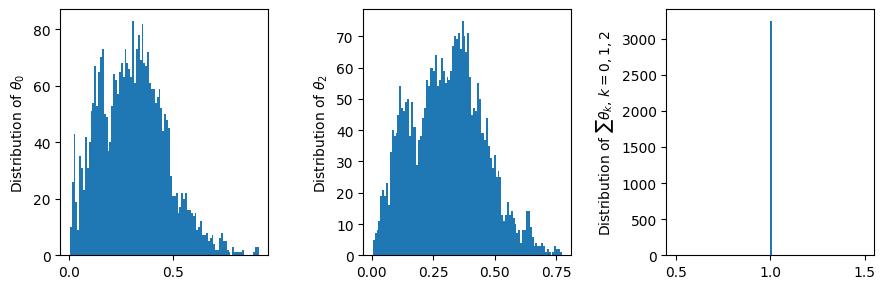

In [31]:
fig,ax=plt.subplots(1,3, figsize=(9,3))
ax[0].hist(to_theta(x_data)[:,0], 100);
ax[0].set_ylabel(r"Distribution of $\theta_0$")
ax[1].hist(to_theta(x_data)[:,1], 100);
ax[1].set_ylabel(r"Distribution of $\theta_2$")
ax[2].hist(to_theta(x_data)[:,0]+to_theta(x_data)[:,1]+(1-(to_theta(x_data)[:,0]+to_theta(x_data)[:,1])), 100);
ax[2].set_ylabel(r"Distribution of $\sum\theta_k$, $k=0,1,2$")
fig.tight_layout()

fig.tight_layout()

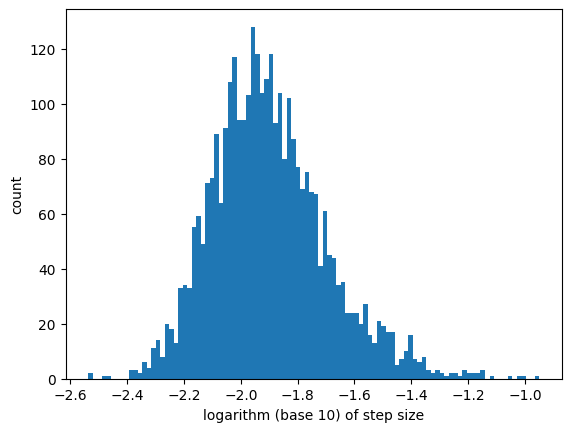

In [32]:
# visualize the different step sizes
fig,ax=plt.subplots(1,1,)
ax.hist(np.log(step_sizes)/np.log(10), 100);
ax.set_xlabel("logarithm (base 10) of step size");
ax.set_ylabel("count");

In [33]:
"""
Plot estimations of the SDE paths in theta space.
Here, the results should match up (except for the differences due to them being sample paths),
even though we work in the transformed variable xi with the network.
"""

data_plot = x_data[0:10000, :]
step_size = 1e-1
T_steps = int(5/step_size)
N_iterates = 5

rng = np.random.default_rng(1)


# EXAMPLE SIR 1 for comparison
def true_drift(x):
    """
    drift for theta 0 and 2.
    """
    theta0 = np.clip(x[:, 0], 0, 1)
    theta2 = np.clip(x[:, 1], 0, 1-theta0)
    theta1 = np.clip(1 - theta0 - theta2, 0, 1)
    r1 = 4*k1*theta0*theta1
    r2 = k2*theta1
    return np.stack([-r1, r2], axis=1)


def true_diffusivity(x):
    """
    Note that the diffusivity here includes _no_ off-diagonal terms!
    So we can just use the diagonal version of the codes.
    """
    theta0 = np.clip(x[:, 0], 0, 1)
    theta2 = np.clip(x[:, 1], 0, 1-theta0)
    theta1 = np.clip(1 - theta0 - theta2, 0, 1)
    r1 = 4*k1*theta0*theta1
    r2 = k2*theta1
    #return np.stack([np.sqrt(r1/N), np.sqrt(r2/N)], axis=1)
    return np.transpose(np.array([[np.sqrt(r1/N), np.zeros(x.shape[0])], [np.zeros(x.shape[0]), np.sqrt(r2/N)]]))


def true_drift_diffusivity(x, param=None):
    return true_drift(x), true_diffusivity(x)


In [34]:
# network parameters
validation_split = .1
AM_validation_split = .1

drift_param = NNHyperparameters(K=2**6, 
                                M_min=10,
                                M_max=200,
                                lambda_reg=2e-3,
                                gamma=1,
                                delta=0.1,
                                name='drift')
diff_param = NNHyperparameters(K=drift_param.K,
                               M_min=drift_param.M_min,
                               M_max=drift_param.M_max,
                               lambda_reg=drift_param.lambda_reg,
                               gamma=drift_param.gamma,
                               delta=drift_param.delta,
                               name='diff')

SAT = SDEAMTrain(n_dimensions=n_dimensions, diff_type="diagonal")

drift epoch: 34


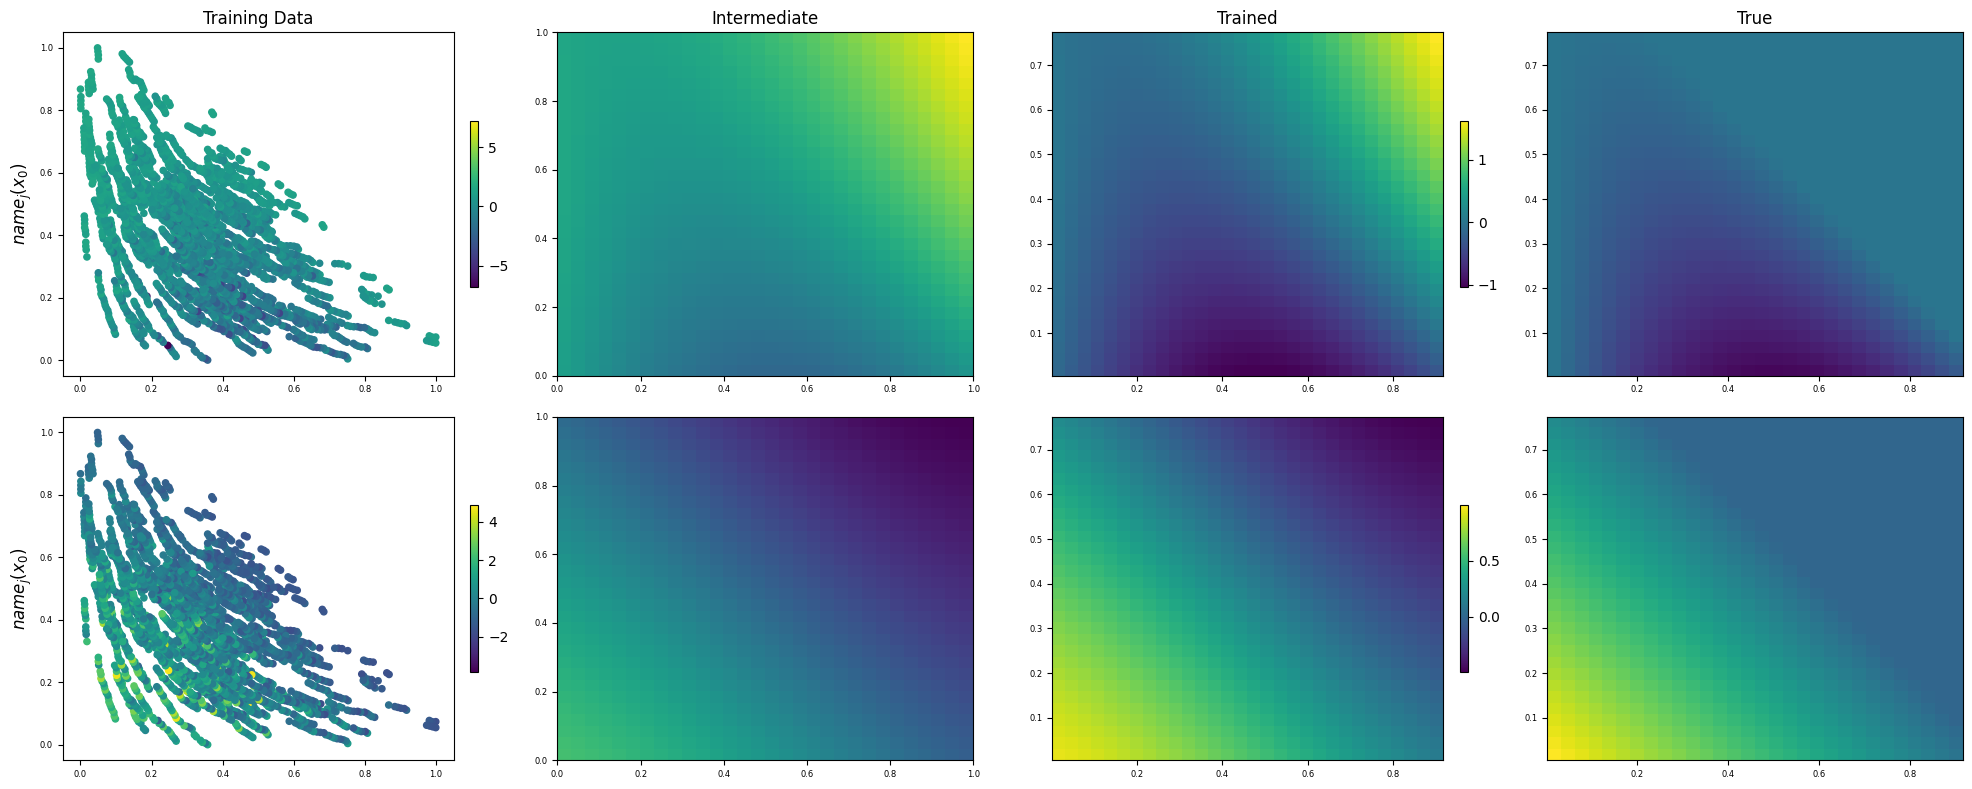

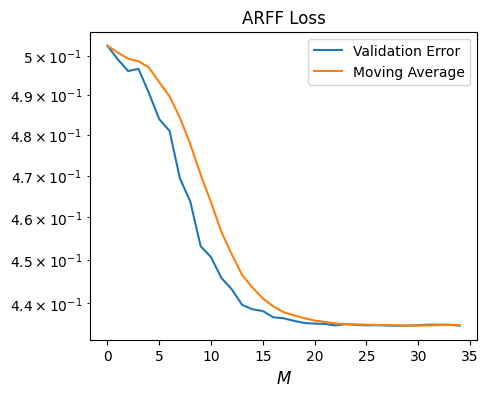

diff epoch: 10


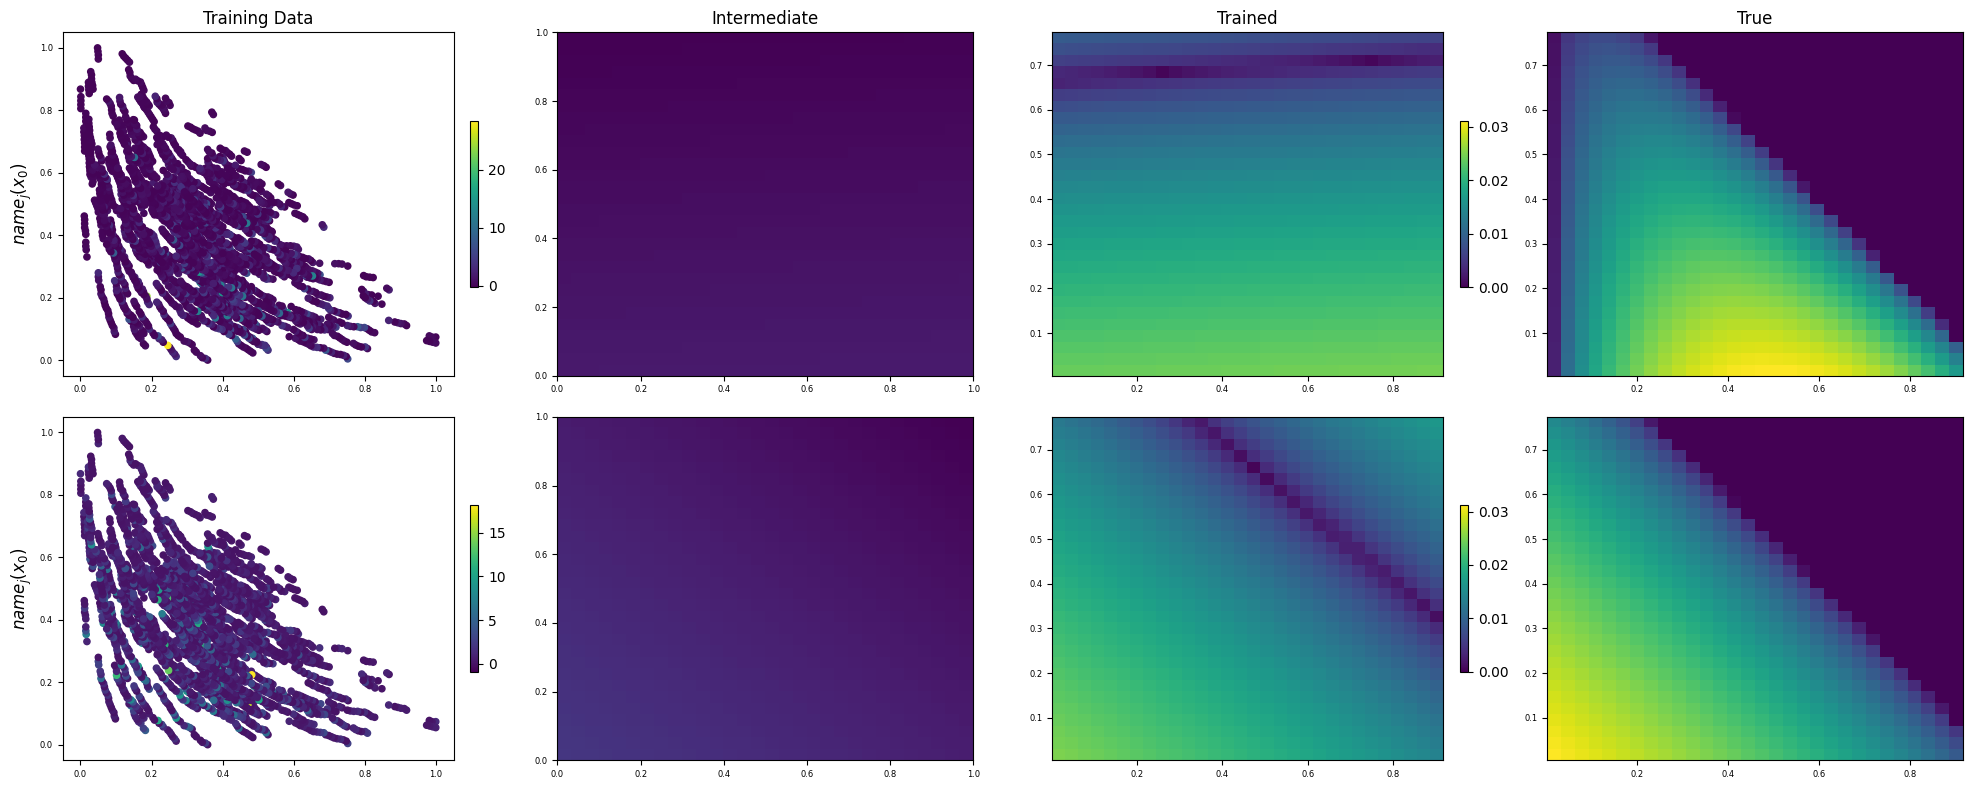

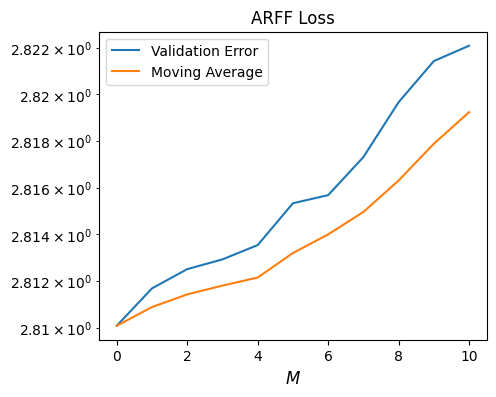

Observed loss: -6.428272773613866
Observed validation loss: -6.489248538225095
 Training time: 0.8069021701812744


In [35]:
No_of_tests = 1
training_time = np.zeros(No_of_tests)
val_loss = np.zeros(No_of_tests)

for i in range(No_of_tests):
    SAT = SDEAMTrain(n_dimensions=n_dimensions, resampling=True)
    hist = SAT.train_model(drift_param, diff_param, true_drift, true_diffusivity, x_data, y_data, step_sizes=step_sizes, validation_split=validation_split, AM_validation_split=AM_validation_split, plot=True)
    training_time[i] = hist.history["training_time"]
    val_loss[i] = hist.history["val_loss"]

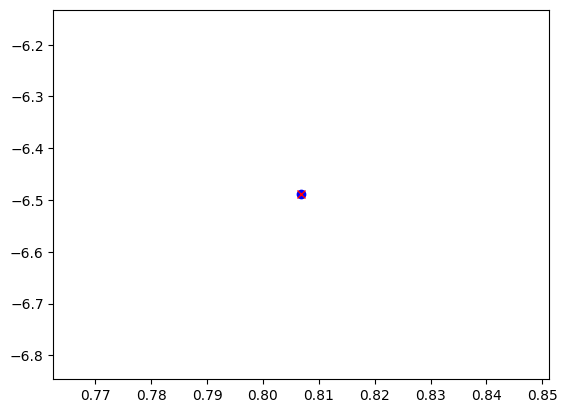

In [36]:
# Calculate the mean
mean_training_time = np.mean(training_time)
mean_val_loss = np.mean(val_loss)

# Calculate the standard deviation above and below the mean for training_time
training_time_above = training_time[training_time > mean_training_time] - mean_training_time
training_time_below = mean_training_time - training_time[training_time < mean_training_time]

std_training_time_above = np.std(np.concatenate((training_time_above, -training_time_above)))
std_training_time_below = np.std(np.concatenate((training_time_below, -training_time_below)))

# Calculate points above and below the mean for val_loss
val_loss_above = val_loss[val_loss > mean_val_loss] - mean_val_loss
val_loss_below = mean_val_loss - val_loss[val_loss < mean_val_loss]

std_val_loss_above = np.std(np.concatenate((val_loss_above, -val_loss_above)))
std_val_loss_below = np.std(np.concatenate((val_loss_below, -val_loss_below)))

# Plot scatter points
plt.scatter(training_time, val_loss, color='blue', label='Data Points')

# Add non-symmetrical error bars (standard deviations)
plt.errorbar(
    mean_training_time, mean_val_loss,
    xerr=[[std_training_time_below], [std_training_time_above]],  # Non-symmetrical x error
    yerr=[[std_val_loss_below], [std_val_loss_above]],  # Non-symmetrical y error
    fmt='x', color='red', ecolor='black', elinewidth=1.5, capsize=4, label='Mean ± STD'
)
plt.show()

# output_dir = os.path.join(script_dir, 'loss_data')
# output_path = os.path.join(output_dir, "ex6 - SIRGillespie wo resampling data.txt")
# with open(output_path, 'w') as file:
#     file.write(f"{mean_training_time},{mean_val_loss},{std_training_time_above},{std_training_time_below},{std_val_loss_above},{std_val_loss_below}\n")


figures_per_row 2


(<Figure size 600x600 with 4 Axes>,
 array([[<AxesSubplot:xlabel='network drift $f_{1}$', ylabel='true drift $f_{1}$'>,
         <AxesSubplot:xlabel='network drift $f_{2}$', ylabel='true drift $f_{2}$'>],
        [<AxesSubplot:xlabel='network diffusivity $\\sigma_{1}$', ylabel='true diffusivity $\\sigma_{1}$'>,
         <AxesSubplot:xlabel='network diffusivity $\\sigma_{2}$', ylabel='true diffusivity $\\sigma_{2}$'>]],
       dtype=object))

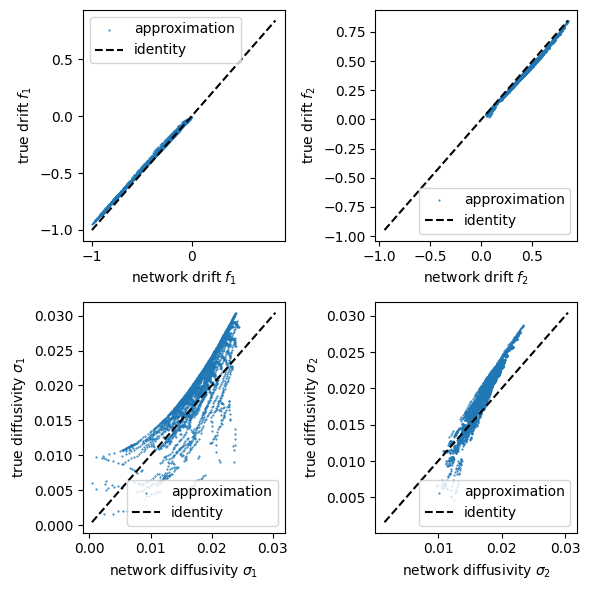

In [37]:
"""
Note that if we use transformations of theta,
the drift and diffusivity are probably not the same functions, even when plotted over their respective domains.
"""
rng = np.random.default_rng(random_state)

plot_results_functions(SAT.drift_diffusivity, true_drift_diffusivity,
                       to_theta(data_plot), to_theta(data_plot), rng,
                       data_transform_network=from_theta, data_transform_true=None)

# output_dir = os.path.join(script_dir, 'trained_vs_true_plots')
# output_path = os.path.join(output_dir, "ex6 - SIRGillespie")
# plt.savefig(output_path, dpi=300, bbox_inches='tight')

(3246, 2)


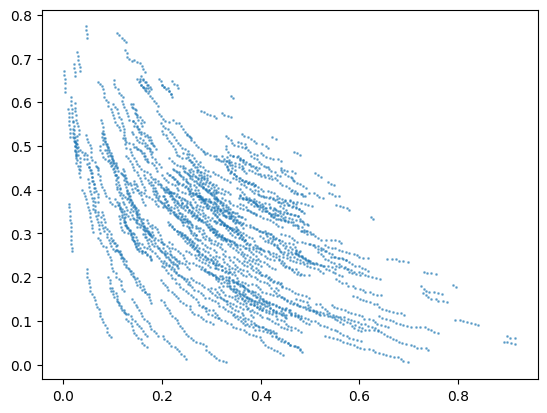

In [46]:
print(x_data.shape)
plt.scatter(x_data[:, 0], x_data[:, 1], s=1, alpha=0.5)

In [ ]:
# create Gillespie training data
rng = np.random.default_rng(random_state)

sirg = SIRG(N=N, k1=k1, k2=k2, k3=0)

x_data = []
y_data = []
times = []
step_sizes = []

y0_all = []

for k in range(n_trajectories):
    # randomly sample the unit cube
    y0 = rng.uniform(low=0.0, high=1.0, size=(3,))

    # transform to sample more points on the boundary
    # y0 = (np.tanh((y0-.5)*5)+1)/2

    # make sure we only sample admissible initial conditions
    y0 = np.clip(y0, 0, 1)
    y0 = y0/np.sum(y0)

    # only take the first two
    y0 = y0[:2]

    y0_all.append(y0)

y0_all = np.row_stack(y0_all)
time_g, y = sirg.simulate(y0_all, time_max = n_time_per_trajectory, time_step=time_step)
#print(y0_all)
#print(time_g)
#print(y)

for k in range(len(y)):
    # skip simulated time steps for the training data, so that the individual points are further apart in time
    time_g[k] = time_g[k][::n_skip_steps]
    y[k] = y[k][::n_skip_steps,:]

    step_sizes.extend(np.gradient(time_g[k])[:-1])

print(len(step_sizes))
print(x_data)

x_data = np.row_stack(x_data)
y_data = np.row_stack(y_data)
step_sizes = np.array(step_sizes)
times = np.array(times)
#print(step_sizes)

def theta02(traj):
    """
    Convert theta12 data to theta02 data (theta0 has "more interesting" trajectories)
    """
    traj_new = traj.copy()
    traj_new[:,0] = 1-(traj[:,0]+traj[:,1])
    return traj_new


# work with (theta0,theta2) data instead of (theta1,theta2) data (the SDE equations we use to compare later are in terms of theta0,2)
x_data = theta02(x_data)
y_data = theta02(y_data)

print("times", times.shape)
print("step sizes shape", step_sizes.shape)
print("x data shape, x0*x1: ", x_data.shape)
print("y data shape, y0*y1: ", y_data.shape)

x_data = from_theta(x_data)
y_data = from_theta(y_data)

0.001953125 0.916015625


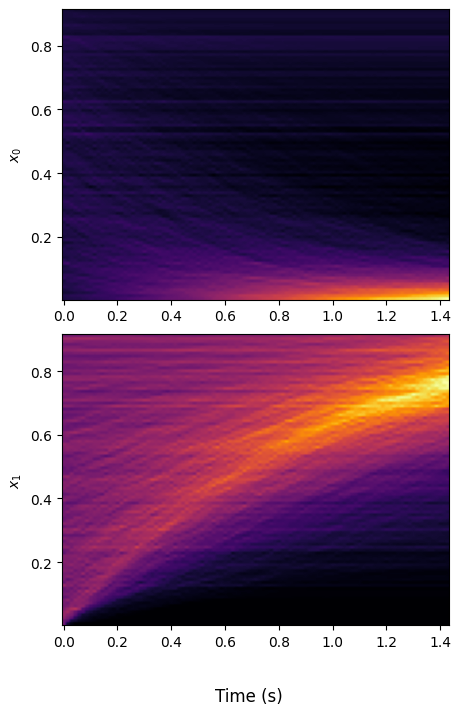

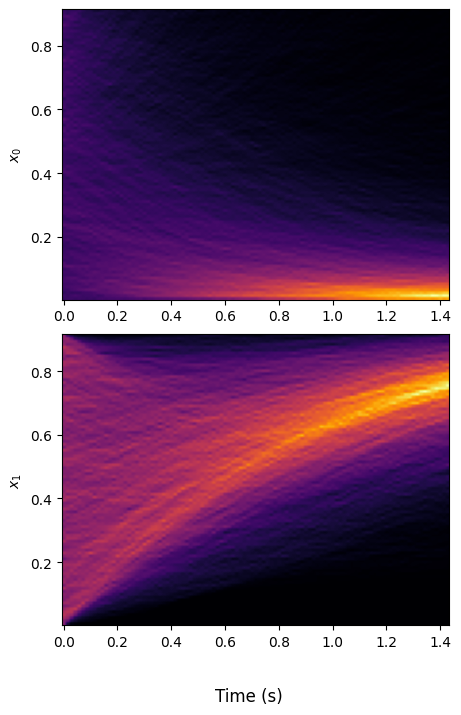

In [41]:
step_size = np.mean(step_sizes)
x_min = np.min(x_data)
x_max = np.max(x_data)



time = 100*step_size

true_paths = histogram_data(true_drift_diffusivity, x_min, x_max, step_size, time, n_dimensions, random_state, Type="gillespie", x_min_initial=0, x_max_initial=1)
ARFF_paths = histogram_data(SAT.drift_diffusivity, x_min, x_max, step_size, time, n_dimensions, random_state)

plot_histogram(true_paths, x_min, x_max, step_size)
plot_histogram(ARFF_paths, x_min, x_max, step_size)

# output_dir = os.path.join(script_dir, 'histogram_data')

# output_path_true = os.path.join(output_dir, "ex6 - SIRGillespie data.txt")
# with open(output_path_true, 'w') as file:
#     file.write(f"{step_size},{x_min},{x_max}\n")

# output_path_true = os.path.join(output_dir, "ex6 - SIRGillespie true.npy")
# np.save(output_path_true, true_paths)

# output_path_ARFF = os.path.join(output_dir, "ex6 - SIRGillespie ARFF.npy")
# np.save(output_path_ARFF, ARFF_paths)

In [37]:
# create sample paths

init_theta0 = 0.9
init_theta1 = 0.1
init_theta2 = 1-(init_theta0+init_theta1)
initial_condition = np.array([init_theta0, init_theta2]).reshape(1,-1)

# the "network" and "true" simulation works with theta 0,2 data
time_steps, paths_network = \
    generate_results(sde_i.drift_diffusivity,
                        step_size, initial_condition,
                        rng, T_steps = T_steps+1, N_iterates=N_iterates,
                        data_transform=from_theta,
                        data_backtransform=to_theta);
time_steps, paths_true = \
    generate_results(true_drift_diffusivity,
                        step_size, initial_condition,
                        rng, T_steps = T_steps+1, N_iterates=N_iterates);


# transform from (theta0, theta2) into (theta1, theta2) - we can use the same transformation function theta02
paths_network12 = [theta02(paths_network[k]) for k in range(len(paths_network))]
paths_true12 = [theta02(paths_true[k]) for k in range(len(paths_true))]

# create Gillespie training data
sirg = SIRG(N=N, k1=k1, k2=k2, k3=0, random_state=random_state)

time_max_test = (T_steps*step_size)

x_data_test = []
times_test = []
for k in range(len(paths_network)):
    y0 = paths_network[k].copy()[0,:]
    # gillespie needs (theta1,theta2) input
    time_g, y = sirg.simulate(theta02(y0.reshape(1,-1)).ravel(), time_max = time_max_test, time_step=time_step)
    
    times_test.append(time_g)
    
    # transform to (theta0,theta2) so that all paths (network, SDE, Gillespie) are in terms of (t0,t2)
    x_data_test.append(theta02(y))

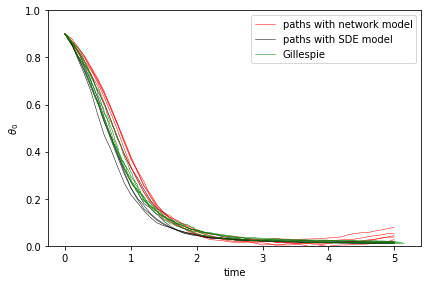

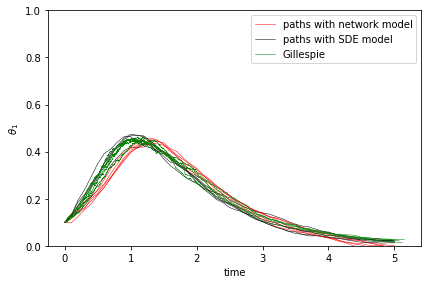

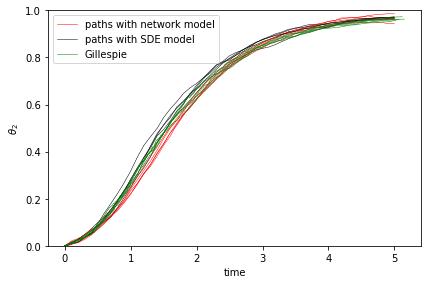

In [38]:
plot_results_1d(time_steps, paths_network, paths_true, plot_dim=0, linewidth=.5);
plt.gca().set_ylim([0,1])
plt.gca().set_ylabel(r"$\theta_0$")

ax = plt.gca()
for k in range(len(x_data_test)):
    ax.plot(times_test[k], x_data_test[k][:,0], linewidth=0.5, color='green', label="Gillespie" if k==0 else None)
ax.legend()

plot_results_1d(time_steps, paths_network12, paths_true12, plot_dim=0, linewidth=.5);
plt.gca().set_ylim([0,1])
plt.gca().set_ylabel(r"$\theta_1$")

# here we want to plot theta1, so we need to transform to it
ax = plt.gca()
for k in range(len(x_data_test)):
    ax.plot(times_test[k], theta02(x_data_test[k])[:,0], linewidth=0.5, color='green', label="Gillespie" if k==0 else None)
ax.legend()

plot_results_1d(time_steps, paths_network, paths_true, plot_dim=1, linewidth=.5);
plt.gca().set_ylim([0,1])
plt.gca().set_ylabel(r"$\theta_2$");

ax = plt.gca()
for k in range(len(x_data_test)):
    ax.plot(times_test[k], x_data_test[k][:,1], linewidth=0.5, color='green', label="Gillespie" if k==0 else None)
ax.legend()


In [39]:
"""
Generate the probability density of all states at a particular time t.
"""

step_size = 1e-2
t_end = 2
rng = np.random.default_rng(random_state)

def gen_results_n(step_size, T_steps, N_iterates):
    """
    Wrapper function so that we do not need to pass all these parameters to "probability_density".
    """
    return generate_results(sde_i.drift_diffusivity,
                            step_size, initial_condition,
                            rng, T_steps=T_steps, N_iterates=N_iterates,
                            data_transform=from_theta,
                            data_backtransform=to_theta)


def gen_results_t(step_size, T_steps, N_iterates):
    """
    Wrapper function so that we do not need to pass all these parameters to "probability_density".
    """
    return generate_results(true_drift_diffusivity,
                            step_size, initial_condition,
                            rng, T_steps=T_steps, N_iterates=N_iterates)


def gen_results_g(step_size, T_steps, N_iterates):
    """
    Wrapper function so that we do not need to pass all these parameters to "probability_density".
    """
    time_max_test = T_steps * step_size
    
    y0 = np.ones((N_iterates, 1)) @ initial_condition.reshape(1, -1)
    
    # gillespie needs (theta1,theta2) input
    time_steps, y = sirg.simulate(theta02(y0), time_max=time_max_test, time_step=step_size)

    # transform to (theta0,theta2) so that all paths (network, SDE, Gillespie) are in terms of (t0,t2)
    path_gillespie = [theta02(y[k]) for k in range(len(y))]
    
    return time_steps, path_gillespie

In [42]:
N_iterates = 100

t0 = time()
pn, time_steps_n, paths_n = probability_density(t=t_end, _generate_results=gen_results_n,
                                                step_size=step_size, rng=rng, N_iterates=N_iterates)
print(f"sampling network took {time()-t0} seconds.")
t0 = time()
pt, time_steps_t, paths_t = probability_density(t=t_end, _generate_results=gen_results_t,
                                                step_size=step_size, rng=rng, N_iterates=N_iterates)
print(f"sampling sde took {time()-t0} seconds.")

t0 = time()
pg, time_steps_g, paths_g = probability_density(t=t_end, _generate_results=gen_results_g,
                                                step_size=step_size, rng=rng, N_iterates=N_iterates)
print(f"sampling gillespie took {time()-t0} seconds.")

sampling network took 14.65221118927002 seconds.
sampling sde took 2.3738646507263184 seconds.
sampling gillespie took 0.026020288467407227 seconds.


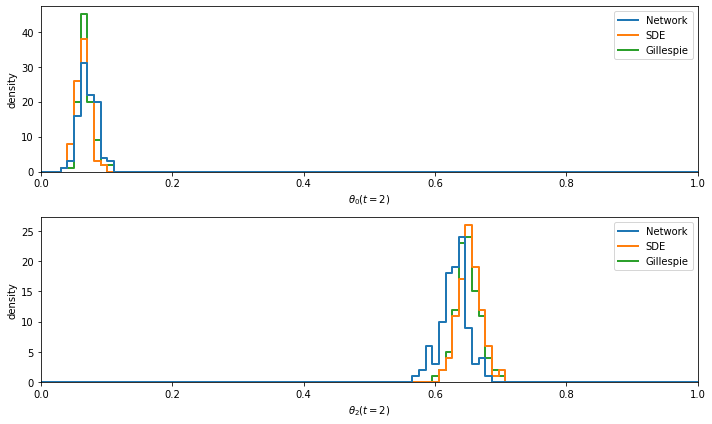

In [47]:
bins = np.linspace(0, 1, 100)
fig,ax = plt.subplots(2,1,figsize=(10,6))
#ax[0].hist(pn, bins, label="network", alpha=0.5);
#ax[0].hist(pt, bins, label="SDE", alpha=0.5);

n1 = pd.DataFrame(pn[:,0], columns=["network 1"])
n2 = pd.DataFrame(pn[:,1], columns=["network 2"])

t1 = pd.DataFrame(pt[:,0], columns=["true 1"])
t2 = pd.DataFrame(pt[:,1], columns=["true 2"])

g1 = pd.DataFrame(pg[:,0], columns=["gillespie 1"])
g2 = pd.DataFrame(pg[:,1], columns=["gillespie 2"])

data1 = pd.DataFrame(np.column_stack([n1, t1, g1]), columns=["Network", "SDE", "Gillespie"])
data2 = pd.DataFrame(np.column_stack([n2, t2, g2]), columns=["Network", "SDE", "Gillespie"])

sns.histplot(data1, ax=ax[0], linewidth=2, bins=bins, line_kws=dict(alpha=.3),
             fill=False, element="step", legend=True)
sns.histplot(data2, ax=ax[1], linewidth=2, bins=bins, line_kws=dict(alpha=.3),
             fill=False, element="step", legend=True)

ax[0].set_xlabel(r"$\theta_0(t="+str(t_end)+")$")
ax[0].set_ylabel("density")
ax[1].set_xlabel(r"$\theta_2(t="+str(t_end)+")$")
ax[1].set_ylabel("density")
#ax[0].set_ylim([0,5])
#ax[1].set_ylim([0,5])

ax[0].set_xlim([0,1])
ax[1].set_xlim([0,1])

fig.tight_layout()